<a href="https://colab.research.google.com/github/dkanh6/EIS-ML/blob/main/data_load_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem at Hand:**
We need to extract, clean, and merge experimental data from multiple sources (TXT files and excel files)

# **General Data Structure:**
1. **TXT Files:**

  *  **Header:** Contains metadata

  *  **Trace A:** Holds the impedance frequency values and the REAL part of the impedance.

  *  **Trace B:** Holds the IMAGINARY part of the impedance *(I hope)*

2. **Excel Files:**
  Contain full experiment details (contains circuit paramters such as capacitance values in the CPEb-T(+) column) and reference the TXT files via a file path embedded in a “Model:” column.
3. **Directory Structure:**
  The data is organized in a hierarchical structure under the root folder (Data).

  * **Experiments:**
    1. Control test (no bacteria)
    2. Test 5E2 (questionable death)
    3. Test 5E3 (marginal death data)
    4. Test 5E4 (death data)
    5. Test 5E5 (death data)

  * Each experiment represents a different starting bacterial concentration (from 5E2 CFU to 5E5 CFU).

  * Within Each Experiment:
    * There are 3 Cartridges (Cartridge 1, 2, and 3).
    * Each cartridge is measured at 12 timepoints (30 minutes apart).
    * For each timepoint, 5 samples are taken (e.g., files named 1-1-1.txt, 1-1-2.txt, … for Cartridge 1 at timepoint 1).



In [1]:
# 1) Clone the repository
!git clone https://github.com/dkanh6/EIS-ML.git
%cd EIS-ML

import os
import glob
import pandas as pd
import numpy as np
import re



# for dirpath, dirnames, filenames in os.walk('Data'):
#     print('Current Path:', dirpath)
#     print('Directories:', dirnames)
#     print('Files:', filenames)
#     print()


def extract_exp_key(filename):
    match = re.search(r'(\d+-\d+-\d+)', filename)
    if match:
        return match.group(1).strip().lower()
    return ""



def parse_path_metadata(filepath):
    # Split the complete file path into a list using the OS separator.
    parts = filepath.split(os.sep)
    # If there are fewer than 3 parts, we cannot extract everything so jsut return defaults.
    if len(parts) < 3:
        return None, None, None, None, ""
    # The experiment folder is the third-to-last part in the path.
    experiment_folder = parts[-3]
    # The cartridge folder is the second-to-last part in the path.
    cartridge_folder  = parts[-2]
    # Get just the filename (without directory paths).
    filename = os.path.basename(filepath)
    # Convert the filename to lowercase and extract the experiment key (a pattern like "2-10-3") using extract_exp_key.
    key = extract_exp_key(filename.lower())
    # Remove the ".txt" extension from the filename, convert to lowercase, and split it by '-'
    tokens = filename.lower().replace(".txt", "").split('-')
    # Initialize timepoint and subsample as None.
    timepoint = None
    subsample = None
    # If the filename splits into exactly three tokens, try converting the second and third tokens to integers.
    if len(tokens) == 3:
        try:
            timepoint = int(tokens[1])
            subsample = int(tokens[2])
        except ValueError:
            # If conversion fails, leave timepoint and subsample as None.
            pass
    # Return a tuple containing the experiment folder, cartridge folder, timepoint, subsample, and experiment key.
    return experiment_folder, cartridge_folder, timepoint, subsample, key

# Reads a TXT file and extracts impedance data from two traces A and B
def parse_txt_file(filepath):
    """
    Reads a TXT file containing impedance data for two traces (A and B),
    capturing only the first two columns: 'Frequency' and 'Data Trace Real'.
    It ignores any additional columns, such as 'Data Trace Imag'.

    Key points:
      - Checks if the line has "TRACE: B" before "TRACE: A"
        to avoid accidentally matching 'A' within the word "TRACE:".
      - Waits for a header line containing "Frequency" and "Data Trace Real"
        before reading numeric rows.
    """

    with open(filepath, 'r') as f:
        lines = f.readlines()

    trace_A = {'frequency': [], 'real': []}
    trace_B = {'frequency': [], 'real': []}

    current_trace = None
    reading_data = False

    for line in lines:
        line = line.strip()

        # Detect a trace marker
        if "TRACE:" in line:
            # Must check "TRACE: B" first:
            if "TRACE: B" in line:
                current_trace = 'B'
            elif "TRACE: A" in line:
                current_trace = 'A'
            # Reset data reading whenever a new trace marker is found
            reading_data = False
            continue

        # "FORMAT:" lines end data reading for that trace
        if "FORMAT:" in line:
            reading_data = False
            continue

        # A header row containing both "Frequency" and "Data Trace Real"
        # signals that subsequent lines are numeric data
        if "Frequency" in line and "Data Trace Real" in line:
            reading_data = True
            continue

        # Skip blank lines
        if not line:
            continue

        # If in reading mode, parse the first two columns for freq + real
        if reading_data and current_trace is not None:
            parts = line.split()
            if len(parts) >= 2:
                try:
                    freq = float(parts[0])
                    real_value = float(parts[1])
                    if current_trace == 'A':
                        trace_A['frequency'].append(freq)
                        trace_A['real'].append(real_value)
                    else:
                        trace_B['frequency'].append(freq)
                        trace_B['real'].append(real_value)
                except ValueError:
                    # If either column fails to parse, skip the line
                    continue

    return trace_A, trace_B




# Function: build_master_dataframe
# Walks through all subdirectories of base_dir (using os.walk) and processes each TXT file (ignoring files containing "placeholder" vestigial tail I havent removed in some foldes when uplaoding to github).
# For each text file it extracts metadata and impedance data, then returns a DataFrame of all records.
# -------------------------------------------------------------------
def build_master_dataframe(base_dir):
    samples = [] # Initialize an empty list to hold a record (dictionary) for each TXT file.

    # Walk through all directories and subdirectories starting at base_dir.
    for root, dirs, files in os.walk(base_dir):

        # Iterate over each file in the current directory.
        for file in files:
            # Check if the file name (in lowercase) ends with '.txt' and does not contain "placeholder".
            if file.lower().endswith(".txt") and "placeholder" not in file.lower():

                # Construct the full path to the file by joining the current root directory with the file name.
                fp = os.path.join(root, file)

                # Extract metadata from the file path:
                # This includes: experiment (folder 3 from the end), cartridge (folder 2 from the end),
                # timepoint and subsample (parsed from the filename), and an experiment key (exp_key).
                experiment, cartridge, timepoint, subsample, exp_key = parse_path_metadata(fp)

                # If essential metadata (experiment or cartridge) is missing, skip processing this file.
                if experiment is None or cartridge is None:
                    continue

                # Parse the TXT file to extract impedance data.
                # The file is expected to contain two traces:Trace A & B (real and img (hopefully))
                trace_A, trace_B = parse_txt_file(fp)

                # Create a dictionary that stores all the extracted information.
                record = {
                    "experiment": experiment,    # The experiment folder name.
                    "cartridge": cartridge,      # The cartridge folder name.
                    "timepoint": timepoint,      # The timepoint parsed from the filename.
                    "subsample": subsample,      # The subsample number parsed from the filename.
                    "trace_A": trace_A,          # Dictionary with frequency, real, and imag for Trace A.
                    "trace_B": trace_B,          # Dictionary with frequency, real, and imag for Trace B.
                    "filepath": fp,              # Full path to the TXT file.
                    "exp_key": exp_key           # Extracted experiment key from the filename.
                }

                # Append the record to the list of samples.
                samples.append(record)

    # Convert the list of records (dictionaries) into a Pandas DataFrame.
    return pd.DataFrame(samples)


# Reads an Excel file It processes# sheets 2-4 (ignoring the first sheet to get to the cartridge sheets)
def parse_excel_full_data(excel_path):
    # Open the Excel file and get information about its sheets.
    xls = pd.ExcelFile(excel_path)
    # If the file doesn't have at least 4 sheets, return an empty DataFrame.
    if len(xls.sheet_names) < 4:
        return pd.DataFrame()

    # We are going to process sheets 2, 3, and 4 (ignoring the first sheet).
    data_sheets = xls.sheet_names[1:4]
    # Create an empty list to collect DataFrames from each processed sheet.
    all_rows = []

    # Loop over each sheet we want to process.
    for sheet in data_sheets:
        # Read the sheet into a DataFrame, skipping the first 16 rows (headers/extra info).
        df_sheet = pd.read_excel(xls, sheet_name=sheet, skiprows=16, header=0)
        # If the DataFrame is empty, skip this sheet.
        if df_sheet.empty:
            continue
        # Find any column name that starts with "model:" (case-insensitive).
        model_cols = [c for c in df_sheet.columns if c.lower().startswith("model:")]
        # If such a column exists, rename the first one to "Model"; otherwise, skip this sheet.
        if model_cols:
            df_sheet.rename(columns={model_cols[0]: "Model"}, inplace=True)
        else:
            continue

        # Convert the "Model" column values to strings.
        df_sheet["Model"] = df_sheet["Model"].astype(str)
        # Create a mask for rows where "Model" contains ".txt" (ignoring case).
        mask = df_sheet["Model"].str.lower().str.contains(".txt", na=False)
        # Use the mask to filter the DataFrame.
        sub = df_sheet[mask].copy()
        # If no rows match, skip this sheet.
        if sub.empty:
            continue
        # Extract a file path from the "Model" column using a regex pattern.
        sub["filepath"] = sub["Model"].str.lower().str.extract(r'(d:.*\.txt)', expand=False)
        # Add a new column with the sheet name.
        sub["sheet_name"] = sheet
        # Add a new column containing the Excel file path.
        sub["excel_file"] = excel_path
        # Extract the experiment key from the basename of the file path using extract_exp_key.
        sub["exp_key"] = sub["filepath"].apply(lambda x: extract_exp_key(os.path.basename(x)) if pd.notnull(x) else "")
        # For each column that might contain vestigial "average" rows, remove rows where the value is "average".
        for col_to_check in ["Unnamed: 24", "Concentration (CFU/ml)"]:
            if col_to_check in sub.columns:
                sub = sub[~sub[col_to_check].astype(str).str.lower().eq("average")]
        # Drop duplicate rows based on the "filepath" column.
        sub = sub.drop_duplicates(subset=["filepath"])
        # Add the processed DataFrame for this sheet to our list.
        all_rows.append(sub)

    # If we processed any sheets, concatenate all the DataFrames into one; otherwise, return an empty DataFrame.
    if all_rows:
        return pd.concat(all_rows, ignore_index=True)
    else:
        return pd.DataFrame()


# Merges the TXT and Excel DataFrames based on "exp_key" and updates a global
def merge_txt_excel_data(df_txt, df_excel):
    # Merge the DataFrame from TXT files (df_txt) with the one from Excel (df_excel)
    # on the common column "exp_key" using a left join (all TXT rows kept).
    merged_df = pd.merge(df_txt, df_excel, on="exp_key", how="left", suffixes=("", "_excel"))
    # Update (or create) a global DataFrame named df_global_merged for later analysis.
    global df_global_merged
    try:
        # If df_global_merged already exists, concatenate the new merged DataFrame to it.
        df_global_merged = pd.concat([df_global_merged, merged_df], ignore_index=True)
    except NameError:
        # Otherwise, create it as a copy of the current merged DataFrame.
        df_global_merged = merged_df.copy()
    # Return the merged DataFrame.
    return merged_df


# Applies the 3-sigma rule to detect outliers.
def is_outlier_3sigma(values, z_threshold=2):
    # Convert the input values to numeric (non-convertible values become NaN).
    vals = pd.to_numeric(values, errors='coerce')
    # Calculate the mean of these numeric values.
    mean_ = vals.mean()
    # Calculate the sample standard deviation (with ddof=1) of the values.
    std_ = vals.std(ddof=1)
    # If the standard deviation is 0 or not a number, return a Series of False (no outliers).
    if std_ == 0 or np.isnan(std_):
        return pd.Series([False] * len(vals), index=vals.index)
    # Compute z-scores for each value: (value - mean) divided by the standard deviation.
    z_scores = (vals - mean_) / std_
    # Return a boolean Series: True where the absolute z-score is greater than the threshold.
    return abs(z_scores) > z_threshold


# Processes one experiment folder by:
#   1) Building the TXT DataFrame.
#   2) Finding and parsing one Excel file.
#   3) Merging the TXT and Excel data.
#   4) Dropping unwanted columns.
#   5) Checking for missing capacitance data and marking valid rows.
#   6) Detecting outliers in the "CPEb-T(+)" column.
#   7) Printing ONLY the outlier summary and the final TXT vs. Excel match summary for ease in quickly determining if things are all okay
def process_experiment_folder(experiment_dir):
    # Step 1: Build the TXT DataFrame by processing all TXT files in the given experiment folder.
    # build_master_dataframe uses os.walk to scan all subdirectories and extract data from each TXT file.
    df_txt = build_master_dataframe(experiment_dir)

    # If no TXT files were found, exit the function.
    if df_txt.empty:
        return

    # Step 2: Find exactly one Excel (.xlsx) file in the folder.
    # Use glob to look for any Excel file in the experiment directory.
    excel_files = glob.glob(os.path.join(experiment_dir, "*.xlsx"))
    # If no Excel file is found, exit the function.
    if not excel_files:
        return
    # Select the first Excel file found.
    excel_file_path = excel_files[0]

    # Step 3: Parse the Excel file to extract its data into a DataFrame.
    # parse_excel_full_data reads sheets 2-4, extracts relevant rows, and creates a DataFrame.
    df_excel = parse_excel_full_data(excel_file_path)

    # If the Excel DataFrame is not empty, further extract additional metadata (experiment and cartridge)
    # from the "filepath" column using parse_path_metadata.
    if not df_excel.empty:
        parse_cols = df_excel["filepath"].apply(parse_path_metadata)
        # The first element of the tuple is the experiment folder.
        df_excel["excel_experiment"] = parse_cols.apply(lambda x: x[0])
        # The second element of the tuple is the cartridge folder.
        df_excel["excel_cartridge"]  = parse_cols.apply(lambda x: x[1])
    else:
        # If the Excel DataFrame is empty, set the new columns to NaN.
        df_excel["excel_experiment"] = np.nan
        df_excel["excel_cartridge"]  = np.nan

    # Step 4: Merge the TXT and Excel DataFrames using the common key "exp_key".
    # merge_txt_excel_data performs a left join (keeping all TXT records) and also updates a global merged DataFrame.
    merged = merge_txt_excel_data(df_txt, df_excel)

    # Remove duplicate TXT file records based on the "filepath" column.
    merged_unique = merged.drop_duplicates(subset=["filepath"]).copy()

    # Drop columns that are not needed for further analysis.
    unwanted_cols = ["excel_experiment", "excel_cartridge", "Unnamed: 24", "Concentration (CFU/ml)"]
    merged_unique.drop(columns=unwanted_cols, inplace=True, errors="ignore")

    # Step 5: Process the capacitance data.
    # Convert the "CPEb-T(+)" column values to numeric (non-numeric values will become NaN).
    merged_unique["CPEb-T(+)"] = pd.to_numeric(merged_unique["CPEb-T(+)"], errors="coerce")
    # Create a new boolean column "excel_data_ok" that is True when there is a valid sheet name
    # and the "CPEb-T(+)" value is not NaN.
    merged_unique["excel_data_ok"] = merged_unique["sheet_name"].notna() & (~merged_unique["CPEb-T(+)"].isna())
    # Duplicate the "excel_data_ok" column into a "match" column for easier reference.
    merged_unique["match"] = merged_unique["excel_data_ok"]

    # Step 6: Outlier detection on the "CPEb-T(+)" column.
    # Create a mask for rows with valid Excel data.
    valid_mask = merged_unique["excel_data_ok"]
    # Use the is_outlier_3sigma function with a z-score threshold of 2.5 to flag outliers in the "CPEb-T(+)" column.
    outlier_mask = is_outlier_3sigma(merged_unique.loc[valid_mask, "CPEb-T(+)"], z_threshold=2.5)
    # Initialize a new column "is_outlier" with False for all rows.
    merged_unique["is_outlier"] = False
    # For rows with valid Excel data, set "is_outlier" to True where the outlier mask is True.
    merged_unique.loc[valid_mask, "is_outlier"] = outlier_mask.values
    # Count the total number of outliers detected.
    n_outliers = merged_unique["is_outlier"].sum()
    # Print a message: if outliers are found, print the count; otherwise, indicate that no outliers were found.
    if n_outliers > 0:
        print(f"Number of outliers found: {n_outliers}")
    else:
        print("No outliers found in this folder.")

    # Step 7: Summarize the matching between TXT and Excel data.
    # (A) Create a summary from the TXT side: group by experiment and cartridge,
    # count the total number of TXT files and how many have a matching Excel row.
    summary_txt = merged_unique.groupby(["experiment", "cartridge"])["match"].agg(
        total_txt_files="count", matched_excel="sum"
    ).reset_index()
    # Calculate unmatched TXT files as the difference between total TXT files and those matched with Excel.
    summary_txt["unmatched"] = summary_txt["total_txt_files"] - summary_txt["matched_excel"]

    # (B) Create a summary from the Excel side: count how many TXT files were referenced in the Excel data.
    if not df_excel.empty:
        df_excel_filtered = df_excel.drop_duplicates(subset=["filepath"])
        excel_summary = df_excel_filtered.groupby(["excel_experiment", "excel_cartridge"]).size().reset_index(name="excel_txt_count")
    else:
        excel_summary = pd.DataFrame(columns=["excel_experiment", "excel_cartridge", "excel_txt_count"])
    # Rename columns in the Excel summary to match those in the TXT summary.
    excel_summary = excel_summary.rename(columns={"excel_experiment": "experiment", "excel_cartridge": "cartridge"})
    # Merge the two summaries on experiment and cartridge.
    summary_merged = pd.merge(summary_txt, excel_summary, on=["experiment", "cartridge"], how="left")
    # Replace any missing values in "excel_txt_count" with 0 and convert to integer.
    summary_merged["excel_txt_count"] = summary_merged["excel_txt_count"].fillna(0).astype(int)

    # Print the final summary of TXT vs. Excel matches.
    print("\nSummary of TXT vs. Excel matches:")
    print(summary_merged.to_string(index=False))

# -------------------------------------------------------------------
# Main Loop: Process each experiment folder under the "Data" directory.
# -------------------------------------------------------------------
pd.set_option('display.float_format', lambda x: f"{x:.9g}")
base_data_dir = "Data"

# Get a list of all subdirectories in the Data directory.
all_experiment_folders = []
for name in os.listdir(base_data_dir):
    full_path = os.path.join(base_data_dir, name)
    if os.path.isdir(full_path):
        all_experiment_folders.append(full_path)

# Process each experiment folder.
for exp_folder in all_experiment_folders:
    process_experiment_folder(exp_folder)


Cloning into 'EIS-ML'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1237 (delta 25), reused 10 (delta 10), pack-reused 1188 (from 1)
Receiving objects: 100% (1237/1237), 3.40 MiB | 8.83 MiB/s, done.
Resolving deltas: 100% (1058/1058), done.
/content/EIS-ML
No outliers found in this folder.

Summary of TXT vs. Excel matches:
                      experiment            cartridge  total_txt_files  matched_excel  unmatched  excel_txt_count
test-5e5-07242020-G (death data) test-5e5-c1-07242020               51             51          0                0
test-5e5-07242020-G (death data) test-5e5-c2-07242020               49             49          0                0
test-5e5-07242020-G (death data) test-5e5-c3-07242020               50             50          0                0
No outliers found in this folder.

Summary of TXT vs. Excel matches:
              experiment           cartrid

['experiment', 'cartridge', 'timepoint', 'subsample', 'trace_A', 'trace_B', 'filepath', 'exp_key', 'Model', 'Chi-Sqr', 'Sum-Sqr', 'Le(±)', 'Le(Error)', 'Le(Error%)', 'Re(±)', 'Re(Error)', 'Re(Error%)', 'CPEe-T(+)', 'CPEe-T(Error)', 'CPEe-T(Error%)', 'CPEe-P(+)', 'CPEe-P(Error)', 'CPEe-P(Error%)', 'Rb(+)', 'Rb(Error)', 'Rb(Error%)', 'CPEb-T(+)', 'CPEb-T(Error)', 'CPEb-T(Error%)', 'CPEb-P(+)', 'CPEb-P(Error)', 'CPEb-P(Error%)', 'Bulk Capacitance (CPEb-T)', '% Change', 'Std dev', 'filepath_excel', 'sheet_name', 'excel_file', 'Le(+)']

First 5 rows of merged data:


,experiment,cartridge,timepoint,subsample,trace_A,trace_B,filepath,exp_key,Model,Chi-Sqr,...,CPEb-P(+),CPEb-P(Error),CPEb-P(Error%),Bulk Capacitance (CPEb-T),% Change,Std dev,filepath_excel,sheet_name,excel_file,Le(+)
0,test-5e5-07242020-G (death data),test-5e5-c3-07242020,1,5,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",Data/test-5e5-07242020-G (death data)/test-5e5...,3-1-5,D:\Google Drive\Research\data\2020-TB\test-5e5...,0.00016253,...,0.96423,0.0010712,0.11109,1.5954e-12,0.232455865,2.52264907e-14,d:\google drive\research\data\2020-tb\test-5e5...,C3,Data/test-5e5-07242020-G (death data)/test-5e5...,NaN
1,test-5e5-07242020-G (death data),test-5e5-c3-07242020,7,2,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",Data/test-5e5-07242020-G (death data)/test-5e5...,3-7-2,D:\Google Drive\Research\data\2020-TB\test-5e5...,0.00015593,...,0.96822,0.001015,0.10483,1.473e-12,-1.70432554,2.09270758e-14,d:\google drive\research\data\2020-tb\test-5e5...,C3,Data/test-5e5-07242020-G (death data)/test-5e5...,NaN
2,test-5e5-07242020-G (death data),test-5e5-c3-07242020,2,2,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",Data/test-5e5-07242020-G (death data)/test-5e5...,3-2-2,D:\Google Drive\Research\data\2020-TB\test-5e5...,0.00014219,...,0.96597,0.00099752,0.10327,1.5529e-12,0.705568021,1.20609563e-14,d:\google drive\research\data\2020-tb\test-5e5...,C3,Data/test-5e5-07242020-G (death data)/test-5e5...,NaN
3,test-5e5-07242020-G (death data),test-5e5-c3-07242020,9,4,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",Data/test-5e5-07242020-G (death data)/test-5e5...,3-9-4,D:\Google Drive\Research\data\2020-TB\test-5e5...,0.00016075,...,0.96764,0.0010336,0.10682,1.498e-12,-0.819661277,5.53376002e-15,d:\google drive\research\data\2020-tb\test-5e5...,C3,Data/test-5e5-07242020-G (death data)/test-5e5...,NaN
4,test-5e5-07242020-G (death data),test-5e5-c3-07242020,4,4,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",Data/test-5e5-07242020-G (death data)/test-5e5...,3-4-4,D:\Google Drive\Research\data\2020-TB\test-5e5...,0.00015543,...,0.96696,0.0010195,0.10543,1.5218e-12,0.84824387,2.58634878e-14,d:\google drive\research\data\2020-tb\test-5e5...,C3,Data/test-5e5-07242020-G (death data)/test-5e5...,NaN



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   experiment                 993 non-null    object 
 1   cartridge                  993 non-null    object 
 2   timepoint                  991 non-null    float64
 3   subsample                  991 non-null    float64
 4   trace_A                    993 non-null    object 
 5   trace_B                    993 non-null    object 
 6   filepath                   993 non-null    object 
 7   exp_key                    993 non-null    object 
 8   Model                      989 non-null    object 
 9   Chi-Sqr                    989 non-null    object 
 10  Sum-Sqr                    989 non-null    object 
 11  Le(±)                      630 non-null    object 
 12  Le(Error)                  989 non-null    object 
 13  Le(Error%)                 989 no

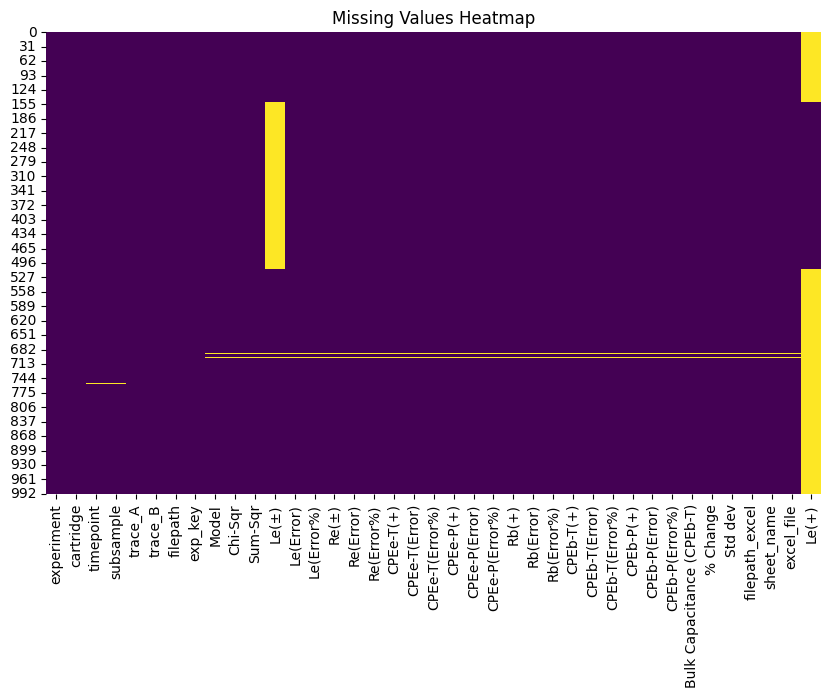

In [5]:
# for quick visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# dropping unwanted columns here because its easier than filtering for it earlier
unwanted_cols = [
    "excel_experiment",
    "excel_cartridge",
    "Unnamed: 24",
    "Concentration (CFU/ml)"
]
df_global_merged.drop(columns=unwanted_cols, inplace=True, errors="ignore")

# basic overview of the data frame
print(df_global_merged.columns.tolist())

print("\nFirst 5 rows of merged data:")
display(df_global_merged.head())

print("\nDataFrame Info:")
df_global_merged.info()

# Missing Values Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df_global_merged.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [8]:
# display the first few rows of the 'trace_B' column
print(df_global_merged['trace_B'].head())
print(df_global_merged['trace_A'].head())

trace_b_first_row = df_global_merged.loc[0, 'trace_B']
print("Contents of trace_B in the first row:")
print(trace_b_first_row)


print("Keys in the trace_B dictionary:", list(trace_b_first_row.keys()))

trace_B_expanded = pd.DataFrame(df_global_merged['trace_B'].tolist())
print("Expanded trace_B data:")
print(trace_B_expanded.head())


0    {'frequency': [1000.0, 1094.889, 1198.782, 131...
1    {'frequency': [1000.0, 1094.889, 1198.782, 131...
2    {'frequency': [1000.0, 1094.889, 1198.782, 131...
3    {'frequency': [1000.0, 1094.889, 1198.782, 131...
4    {'frequency': [1000.0, 1094.889, 1198.782, 131...
Name: trace_B, dtype: object
0    {'frequency': [1000.0, 1094.889, 1198.782, 131...
1    {'frequency': [1000.0, 1094.889, 1198.782, 131...
2    {'frequency': [1000.0, 1094.889, 1198.782, 131...
3    {'frequency': [1000.0, 1094.889, 1198.782, 131...
4    {'frequency': [1000.0, 1094.889, 1198.782, 131...
Name: trace_A, dtype: object
Contents of trace_B in the first row:
{'frequency': [1000.0, 1094.889, 1198.782, 1312.533, 1437.078, 1573.441, 1722.743, 1886.212, 2065.193, 2261.157, 2475.716, 2710.634, 2967.843, 3249.459, 3557.796, 3895.392, 4265.022, 4669.725, 5112.831, 5597.982, 6129.169, 6710.759, 7347.536, 8044.736, 8808.093, 9643.884, 10558.982, 11560.913, 12657.916, 13859.012, 15174.08, 16613.932, 18190.411, 19916